### Mounting your google drive on Colab Noetebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/ 
datapath = './data/VariantEffectPrediction/clinvarHC_modeling.csv.gz'

In [ ]:
#%cd ../

In [2]:
from src.load_libraries_and_data import *  ## aca cargo datos, hago el split, defino variables categóricas, etc. 
Y_train = y_train.ClinvarHC.ravel()
Y_test = y_test.ClinvarHC.ravel()


## además cargo funciones específicas para este notebook
try:
    import category_encoders as ce
except:
    !pip install category_encoders

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

## Para guardar y levantar un objeto en pickle
import joblib as jlb


## Hyperparameter optimization
from sklearn.model_selection import GridSearchCV

try:
    from skopt import BayesSearchCV
except: 
    !pip install scikit-optimize
    
from skopt.space import Real, Categorical, Integer
# para optimizar vía gaussian process (secuencial). 
from skopt import gp_minimize
from skopt import forest_minimize
from skopt.utils import use_named_args
# para visualizar el gp secuencial
from skopt import plots as skplots

### Model explainers via Game Theory
import shap 
try:
    import shap 
except:
    !pip install shap




In [3]:
# notar que en la linea de arriba, hemos cargado todo con lo que venimos trabajando:
print(X.shape)
print(X_train.shape, X_test.shape)
print('')
print('Notar que los transformes ya están cargados')
print(type(categorical_transformer), type(numerical_transformer))
print('')

print('también las columnas categóricas')
print('categorical columnss %s ....'%categorical_columns[0:3])
print('numerical columns %s ....'%numerical_columns[0:3])
print('')

print('semilla para pseudoalearios: %s'%SEED)


(17320, 39)
(8660, 39) (8660, 39)

Notar que los transformes ya están cargados
<class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'>

también las columnas categóricas
categorical columnss ['interpro_domain_simple', 'ess_gene_ess_gene', 'ess_gene_ess_gene_crispr'] ....
numerical columns ['gerp_gerp_nr', 'gerp_gerp_rs', 'linsight_value'] ....

semilla para pseudoalearios: 2718281


In [36]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',RandomForestClassifier(random_state = SEED,n_estimators = 10))])  


In [7]:
rfcv = cross_val_score(pipeline, X_train, Y_train, cv=5,scoring = 'roc_auc')
print(np.mean(rfcv),np.std(rfcv))

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


0.9301134546711977 0.005957978139615323


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


### The wisdom of crowds
#### Sin tunear ningún hiperparámetro, ya estamos arriba de la LR y el DT que hemos tuneado. 

In [8]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Nuevos hiperparámetros en adición a un simple Decision Tree:

***n_estimators*** : número de árboles a utilizar 

***n_jobs :***  RF es fácilmente paralelizable (cada estimador es independiente de los otros)


***max_features***: número de features que usa cada árbol. Notar que aunque el número es igual para todos, ahora cada árbol usa un set de N features distintos!
\### Este ya estaba, en Decision Trees, pero acá toma particuar importancia. De hecho es lo que diferencia conceptuamente a RF de un método convencional de bagging (promediar resultados de clasificadores), que cada árbol no emplea todos los features, usa un subset reducido (distinto de los demás!)  

***oob_score :*** out of bag error. Nos dice para cada feature, cómo cae en promedio el desempeño del modelo en todos los árboles (estimadores) que no lo incluyeron en la selección de features. 




## Explorarción de hiperparámetros
Ver:

__[Acá, explicado cada hyperp]()__  

__[Acá, exploración individual]()__

### Numero de estimadores (árboles)

In [42]:
?RandomForestClassifier

In [47]:
nestimators = np.array([10, 20 , 50, 100, 500])

param_grid = [
  {'clasificador__n_estimators':nestimators}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=3,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, Y_train)

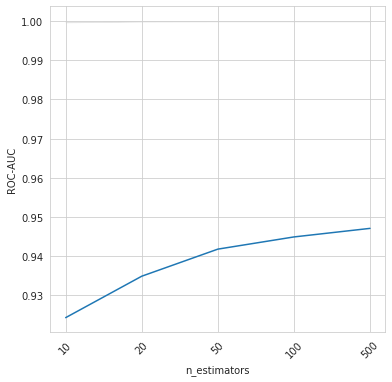

In [48]:
matplotlib.rcParams['figure.figsize'] = [6, 6]

my_train_test_plot(search,param_grid,'n_estimators')

#### Noten que, el train está sobreestimado al máximo y que aumentar el número de estimadores está achicando la brecha de varianza. Es decir, está generalizando mejor.  
* Esa sobreestimación del training hay que pensarla relacionada al seteo por default de los demás hiperparámetros.
* Arboles muy profundos? 
* Hojas de muy pocos elementos? 
* Estamos admintiendo splits muy chiquitos?

.

### Max features

In [37]:
max_features= np.linspace(0.01, 1, 10, endpoint=True)

param_grid = [
  {'clasificador__max_features':max_features}
 ]

search1 = GridSearchCV(pipeline, param_grid, 
                      cv=3,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, Y_train)


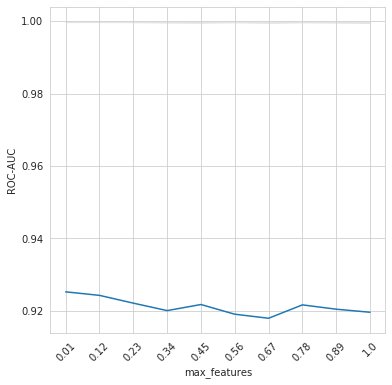

In [38]:
matplotlib.rcParams['figure.figsize'] = [6, 6]
my_train_test_plot(search1,param_grid,'max_features')

### Min Samnples Split

In [52]:
min_samples_splits = np.linspace(0.01, 0.1, 20, endpoint=True)
min_samples_splits = [2,0.001,0.005] +[m for m in min_samples_splits]+ [0.15,0.2,0.3,0.4,0.5,0.6,0.65,0.7,1.0]

param_grid = [
  {'clasificador__min_samples_split':min_samples_splits}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=2,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, Y_train)

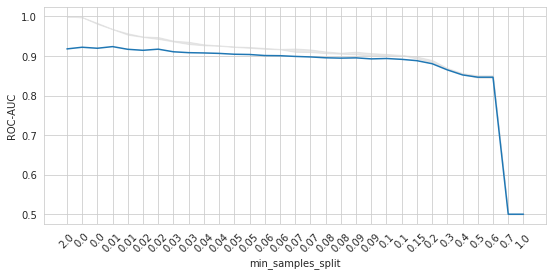

In [50]:
matplotlib.rcParams['figure.figsize'] = [9, 4]

my_train_test_plot(search,param_grid,'min_samples_split')

## Acá frenemos. 
#### Miremos el gráifco y pensemos/ contrastemos con lo que le pasaba a un árbol individual. 
* No cae abrupto el score en el evaluation set cuando reducimos al mínimo el valor de min_samples split.
* Esto es gracias al bagging. Aunque un arbol en particular sobreajuste por permitirle splitear en hojas de muy pocos elementos, el promedio a lo largo de todos los árboles controla el sobreajuste. En pocas palabras, controla complegidad del modelo. 



* De los parámetros que movimos, es el primero hasta ahora que vemos controlar el sobreajuste en el training. 



### Máxima profundiad del arbol admitida (Max Depth)
Otro que controla complegidad. 

In [22]:
max_depths = np.linspace(1, 20, 20, endpoint=True)
max_depths = [int(m) for m in max_depths]  # esto no es necesario, sólo está acá por cómo estamos ploteando


param_grid = [
  {'clasificador__max_depth':max_depths}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=3,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, Y_train)

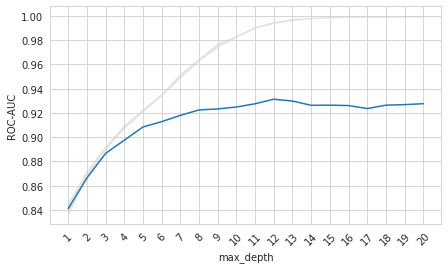

In [23]:
matplotlib.rcParams['figure.figsize'] = [7, 4]
my_train_test_plot(gridsearch=search,grid=param_grid,hyp='max_depth')

## minimal Impurity of leafs

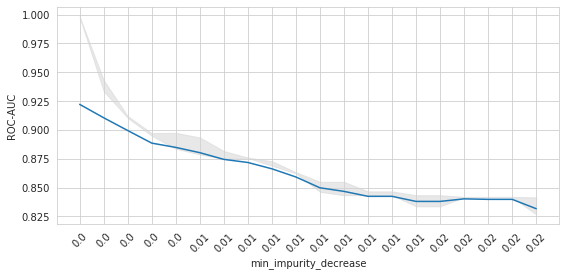

In [61]:
min_impurity_decrease = np.linspace(0,0.02, 20, endpoint=True)

pipeline.named_steps['clasificador'].set_params(**{'min_samples_split': 0.001})  

param_grid = [
  {'clasificador__min_impurity_decrease':min_impurity_decrease}
 ]

search = GridSearchCV(pipeline, param_grid, 
                      cv=2,return_train_score = True,
                     scoring = 'roc_auc').fit(X_train, Y_train)

my_train_test_plot(search,param_grid,'min_impurity_decrease')

.

.

# Vamos a tunear el modelo con tuti.

In [66]:
### Hagamos ahora la optimización vía gp_minimize

## Sólo cambio la forma en que llamé al clasificador.
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('m',RandomForestClassifier(random_state = SEED))])    



### En esta version el espacio de búsqueda lo tengo que definir acorde a skit-optimize
search_space  = [
          Integer(100, 500, name='m__n_estimators'),    
          Integer(3, 15, name='m__max_depth'),
          Real(1e-2, 2e-1, "log-uniform", name='m__min_samples_split'),
          Real(0.01, 0.5, "uniform", name='m__max_features'),
          Real(1e-3, 2e-1, "log-uniform", name='m__min_samples_leaf'),
          Real(1e-8, 1e-1, "log-uniform", name='m__min_impurity_decrease')]

@use_named_args(search_space)
def objective(**params):
    pipeline.set_params(**params)

    return 1.0 - np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'roc_auc'))


ncalls = 10

In [68]:
res_gp = gp_minimize(objective, search_space, n_calls=ncalls, random_state=SEED)

In [69]:
gp_best = pipeline
for i in range(len(res_gp.x)):
    pipeline.set_params(**{search_space[i].name:res_gp.x[i]})
pipeline.named_steps['m']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.18149324426023086,
                       max_leaf_nodes=None,
                       min_impurity_decrease=3.355083997332339e-07,
                       min_impurity_split=None,
                       min_samples_leaf=0.01121312095284378,
                       min_samples_split=0.015131309860239634,
                       min_weight_fraction_leaf=0.0, n_estimators=491,
                       n_jobs=None, oob_score=False, random_state=2718281,
                       verbose=0, warm_start=False)

## Performance en evaluation set

In [70]:
np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'roc_auc'))


0.909637770848674

### Performance sobre el testing set

In [71]:
pipeline = pipeline.fit(X_train,Y_train)

In [72]:
metrics.roc_auc_score(Y_test,pipeline.predict_proba(X_test)[:,1])

0.9121419227825996

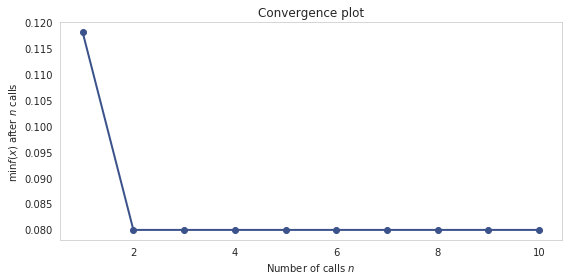

In [76]:
skplots.plot_convergence( res_gp)

### Cómo se lee esto? (obtuvimos peor performance que sin hacer nada!!) 
* Estamos con muy pocas iteraciones para el tamaño del espacio de hiperparámetros que queremos samplear.
* Aumentamos sampling, o cambiamos estrategia de minimización, o ambas. 
* y/o achicamos el espacio 

In [131]:
## Sólo cambio la forma en que llamé al clasificador.
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('m',RandomForestClassifier(random_state = SEED, n_estimators = 500))])    



### En esta version el espacio de búsqueda lo tengo que definir acorde a skit-optimize
search_space  = [
          Integer(3, 25, name='m__max_depth'),
          Real(1e-6, 2e-1, "log-uniform", name='m__min_samples_split'),
          Integer(2, 10, "uniform", name='m__max_features')]
#          Real(1e-3, 2e-1, "log-uniform", name='m__min_samples_leaf')]
#          Real(1e-8, 1e-1, "log-uniform", name='m__min_impurity_decrease')]

@use_named_args(search_space)
def objective(**params):
    pipeline.set_params(**params)

    return 1.0 - np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'roc_auc'))



In [134]:
ncalls = 50
res_fm1 = forest_minimize(objective, search_space, n_calls=ncalls, random_state=SEED,verbose=True)
jlb.dump(res_fm1, 'forest_minimiz1_rf.pkl')

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 28.5448
Function value obtained: 0.0528
Current minimum: 0.0528
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.4983
Function value obtained: 0.0883
Current minimum: 0.0528
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 22.5688
Function value obtained: 0.0556
Current minimum: 0.0528
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 21.1514
Function value obtained: 0.0509
Current minimum: 0.0509
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 27.5108
Function value obtained: 0.0528
Current minimum: 0.0509
Iteration No: 6 started. Evalua

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 24.7571
Function value obtained: 0.0573
Current minimum: 0.0468
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 12.4124
Function value obtained: 0.0660
Current minimum: 0.0468
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 11.4251
Function value obtained: 0.0666
Current minimum: 0.0468
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 17.2772
Function value obtained: 0.0555
Current minimum: 0.0468
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 29.1836
Function value obtained: 0.0532
Current minimum: 0.0468
Iteration No: 46 started

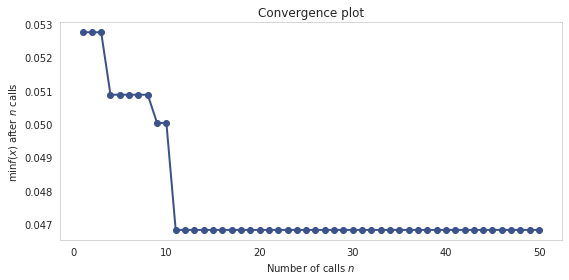

In [136]:
res_fm = res_fm1
skplots.plot_convergence(res_fm)

In [138]:
for i in range(len(res_fm.x)):
    pipeline.set_params(**{search_space[i].name:res_fm.x[i]})
pipeline.named_steps['m']

np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'roc_auc'))

0.9531709547973083

In [146]:
pipeline = pipeline.fit(X_train,Y_train)
metrics.roc_auc_score(Y_test,pipeline.predict_proba(X_test)[:,1])

0.9545665596201265

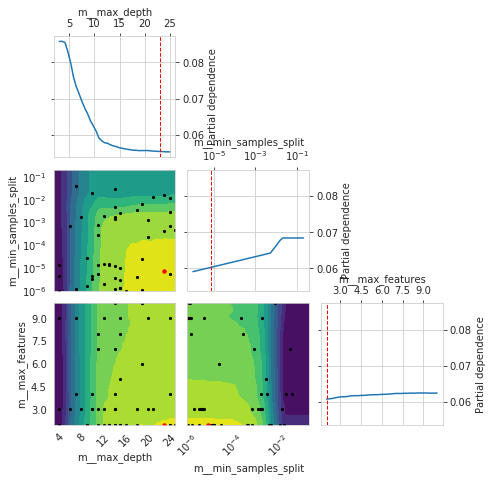

In [140]:
_ = skplots.plot_objective(res_fm)

In [143]:
res = jlb.load('forest_minimiz1_rf.pkl')

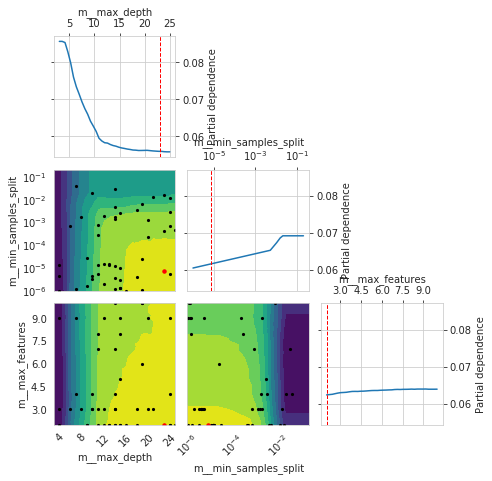

In [144]:
_ = skplots.plot_objective(res)

In [123]:
ncalls = 50
res_gp = gp_minimize(objective, search_space, n_calls=ncalls, random_state=SEED,verbose=True)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 22.5943
Function value obtained: 0.0530
Current minimum: 0.0530
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.5828
Function value obtained: 0.0819
Current minimum: 0.0530
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.3959
Function value obtained: 0.0671
Current minimum: 0.0530
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 18.5539
Function value obtained: 0.0694
Current minimum: 0.0530
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 15.5816
Function value obtained: 0.0781
Current minimum: 0.0530
Iteration No: 6 started. Evalu

The objective has been evaluated at this point before.


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 22.9920
Function value obtained: 0.0515
Current minimum: 0.0515
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 22.8264
Function value obtained: 0.0521
Current minimum: 0.0515
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 23.0173
Function value obtained: 0.0522
Current minimum: 0.0515
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 22.9551
Function value obtained: 0.0518
Current minimum: 0.0515
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 23.0653
Function value obtained: 0.0515
Current minimum: 0.0515
Iteration No: 21 started

The objective has been evaluated at this point before.


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 24.0185
Function value obtained: 0.0518
Current minimum: 0.0515
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 24.4072
Function value obtained: 0.0515
Current minimum: 0.0515
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 22.1456
Function value obtained: 0.0557
Current minimum: 0.0515
Iteration No: 31 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 26.5946
Function value obtained: 0.0518
Current minimum: 0.0515
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 24.6601
Function value obtained: 0.0527
Current minimum: 0.0515
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 23.6116
Function value obtained: 0.0525
Current minimum: 0.0515
Iteration No: 34 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 24.0799
Function value obtained: 0.0515
Current minimum: 0.0515
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 10.6876
Function value obtained: 0.1077
Current minimum: 0.0515
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 22.4390
Function value obtained: 0.0546
Current minimum: 0.0515
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 21.1136
Function value obtained: 0.0561
Current minimum: 0.0515
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 26.5294
Function value obtained: 0.0539
Current minimum: 0.0515
Iteration No: 39 started

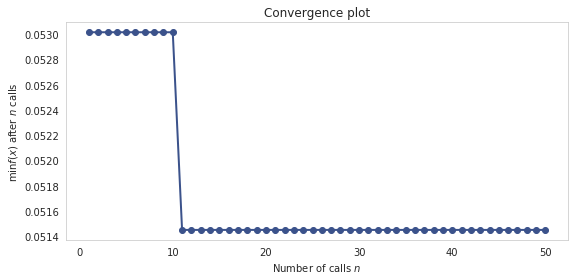

In [127]:
skplots.plot_convergence(res_gp)

In [128]:
gp_best = pipeline
for i in range(len(res_gp.x)):
    pipeline.set_params(**{search_space[i].name:res_gp.x[i]})
pipeline.named_steps['m']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.0001,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=2718281,
                       verbose=0, warm_start=False)

In [129]:
np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'roc_auc'))

0.948549116532839

## Acá viene lo potente:
* puedo explorar el proceso de optimización. 
* Puedo ver dependencias parciales entre hiperparámetros
* Puedo ver si me quedé corto con el rango de  exploración de alguno de ellos
* Ojo con aumentar mucho el rango de exploración de los hyp. y escatimar con el número de calls porque podés caer en un modelo subópimo (piensen que los rangos de búsqueda los definimos habiendo explorado cada hyper individualmente, es decir una solución de orden cero que no considera interacciones de mayor orden).

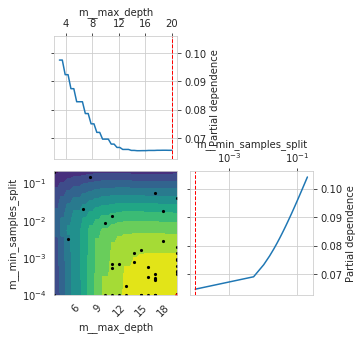

In [130]:
from skopt.plots import plot_objective

_ = plot_objective(res_gp)

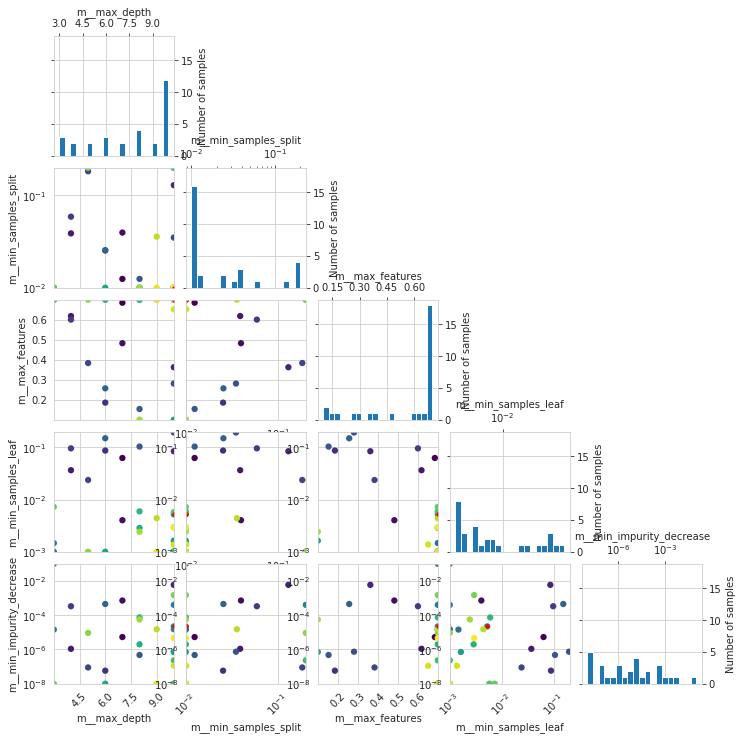

In [150]:
from skopt.plots import  plot_evaluations
_ = plot_evaluations(res_gp)

## Entendiendo nuestro modelo

In [153]:
import shap
#import lime ### hay que verlo (e instalarlo)

In [154]:
be = opt.best_estimator_
pp = be.named_steps['preprocessing']
model = be.named_steps['clasificador']

In [184]:
Xprep = pp.transform(X_train)
Xprep = pd.DataFrame(Xprep)  # preproceso para que SHAP pueda perturbar sin nulls

# recupero nombre de columnas
numerical_names = pp.transformers_[0][2]
categorical_output_names = pp.named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
cols = numerical_names + categorical_output_names
Xprep.columns = cols

Xtrain_sampled = shap.sample(Xprep,1000)

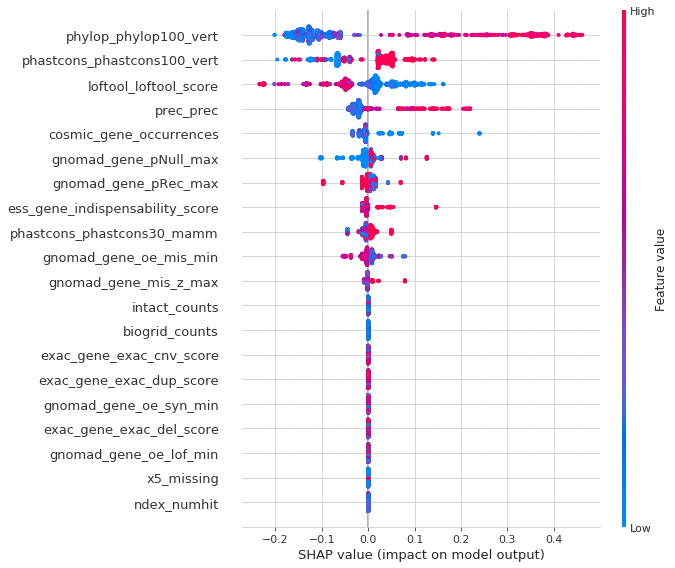

In [185]:
shap_tree_explainer = shap.TreeExplainer(model, Xtrain_sampled,model_output = 'probability')
shap_values = shap_tree_explainer.shap_values(Xtrain_sampled)
shap.summary_plot(shap_values[1], Xtrain_sampled, plot_type="dot")

### Explicando predicciones localmente (a nivel de ítem individual) 
Ojo q es costoso en cálculo

In [186]:
## predicciones 
X_output = pd.DataFrame(pp.transform(X_test))
X_output.columns = cols
X_output.loc[:,'predict'] = np.round(model.predict_proba(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,1000,50) # Every 50 rows
S = X_output.iloc[random_picks]
ii =S.index



def shap_plot(j):
    explainerModel = shap.TreeExplainer(model,S)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value[1], shap_values_Model[1][j],S.iloc[[j]])
    return(p)

In [187]:
shap.initjs()
localplot = shap_plot(ii[0])
localplot

### Interaction plots 
* para entender valor predictivo conjunto de grupos de dos variables

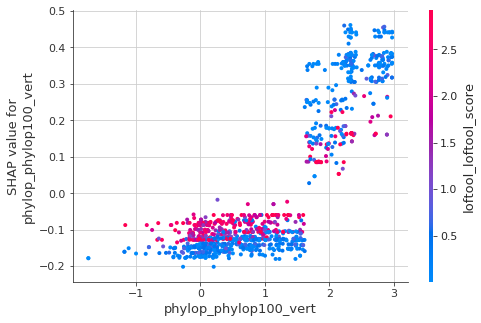

In [188]:
shap.dependence_plot('phylop_phylop100_vert', shap_values[1], Xtrain_sampled)

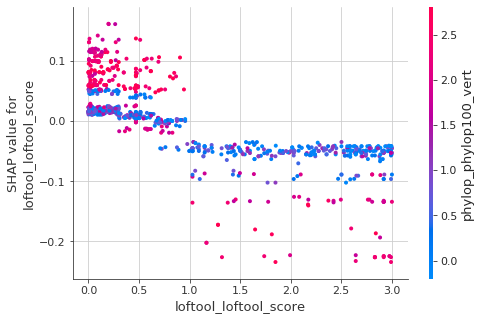

In [189]:
shap.dependence_plot("rank(2)",shap_values[1], Xtrain_sampled)

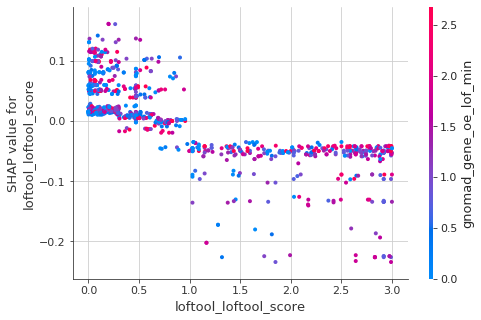

In [190]:
shap.dependence_plot(ind = "rank(2)",shap_values = shap_values[1], features = Xtrain_sampled,interaction_index = "gnomad_gene_oe_lof_min")

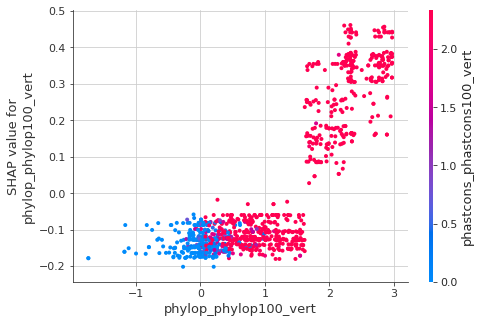

In [193]:
shap.dependence_plot(ind = 'phylop_phylop100_vert',shap_values = shap_values[1], 
                     features = Xtrain_sampled,interaction_index = 'phastcons_phastcons100_vert')

In [194]:
cols

['gerp_gerp_nr',
 'gerp_gerp_rs',
 'linsight_value',
 'phastcons_phastcons100_vert',
 'phastcons_phastcons30_mamm',
 'phylop_phylop100_vert',
 'phylop_phylop100_vert_r',
 'phylop_phylop30_mamm',
 'segway_sum_score',
 'segway_mean_score',
 'brca1_func_assay_score',
 'gtex_counts',
 'repeat_flag',
 'cosmic_gene_occurrences',
 'ess_gene_indispensability_score',
 'ghis_ghis',
 'loftool_loftool_score',
 'ndex_numhit',
 'prec_prec',
 'exac_gene_exac_del_score',
 'exac_gene_exac_dup_score',
 'exac_gene_exac_cnv_score',
 'biogrid_counts',
 'intact_counts',
 'gnomad_gene_oe_lof_min',
 'gnomad_gene_oe_mis_min',
 'gnomad_gene_oe_syn_min',
 'gnomad_gene_lof_z_max',
 'gnomad_gene_mis_z_max',
 'gnomad_gene_syn_z_max',
 'gnomad_gene_pLI_max',
 'gnomad_gene_pRec_max',
 'gnomad_gene_pNull_max',
 'x0_ABC transporter-like',
 'x0_Aromatic amino acid hydroxylase, C-terminal',
 'x0_EGF-like domain',
 'x0_Fibronectin type III',
 'x0_Ion transport domain',
 'x0_Myosin head, motor domain',
 'x0_Serine-threonine/tyrosine-protein kinase, catalytic domain',
 'x0_missing',
 'x0_others',
 'x1_E',
 'x1_N',
 'x1_missing',
 'x2_E',
 'x2_N',
 'x2_missing',
 'x3_E',
 'x3_N',
 'x3_S',
 'x3_missing',
 'x4_E',
 'x4_H',
 'x4_K',
 'x4_N',
 'x4_missing',
 'x5_N',
 'x5_Y',
 'x5_missing']

In [183]:
#shap_tree_explainer = shap.TreeExplainer(model, Xtrain_sampled, feature_perturbation = "tree_path_dependent",model_output = 'raw')
#interaction_values = shap_tree_explainer.shap_interaction_values(Xtrain_sampled)[1]
#shap.decision_plot(shap_tree_explainer.expected_value[1],
#                   interaction_values[1,:,:],feature_names=cols)